<a href="https://colab.research.google.com/github/gabriel92sampaio/sinter_quality_prediction/blob/main/Predi%C3%A7%C3%A3o_RDI_sinter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de RDI do sínter de minério de ferro


1.   Professor: Dr. Daniel Cavalieri e Dr. Adilson Prado
2.   Aluno: Me. Gabriel Assis Sampaio
3.   Valor de RDI cedido pela ArcelorMittal Tubarão.






# Tratamento do sinal

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rampy
import rampy as rp
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
np.random.seed(145)

# Carregar o arquivo financial_distress.csv
data = pd.read_csv('amostras_ramam_rdi.csv')

# Data de cada amostra
saida = data[['Data','RDI']]
# Retira coluna de datas para treinamento e teste
data = data.drop(['Data'], axis = 1)

# Divisão de classes 0 (<15) 1 (>=15 & <=20) 2 (>20)
group0 = saida['RDI'] >= 15
group1 = saida['RDI'] < 15
group2 = saida['RDI'] <= 20

saida['target'] = saida['RDI'].where(group2, 2) 
saida['target'].where(group0, 0, inplace = True) 
saida['target'].where(group1, 1, inplace = True) 
saida['target'].where(group2, 2, inplace = True) 

saida = saida.astype({"target": int})

# Separar dados em vetores de entrada e saída
X = np.array(data.loc[:, data.columns != 'RDI'])
#RDI classes
y = np.array(saida.loc[:,:])

     |████████████████████████████████| 48 kB 726 kB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data.head()

,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,...,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,RDI
0,958.78,984.32,1008.21,1026.80,1045.32,1063.76,1081.49,1091.15,1100.78,1110.36,1119.91,1112.04,1102.71,1093.43,1084.19,1063.90,1040.48,1017.16,993.93,988.46,993.22,997.96,1002.68,1006.77,1010.22,1013.66,1017.09,1020.26,1023.00,1025.73,1028.44,1026.89,1011.81,996.78,981.81,969.90,980.64,991.34,1002.01,1012.61,...,462.55,444.97,427.30,419.97,412.74,385.52,353.98,374.93,422.20,427.10,391.46,359.37,333.75,308.49,284.87,261.01,234.86,208.60,219.36,233.43,217.04,191.81,191.86,206.27,211.57,207.83,182.98,122.10,78.62,90.89,97.51,59.33,20.98,100.53,181.79,135.45,69.25,30.10,2.00,14.90
1,760.81,760.40,769.35,809.60,849.69,889.61,925.83,916.91,908.02,899.17,890.35,892.37,895.29,898.20,901.10,905.02,909.22,913.41,917.58,907.43,889.08,870.80,852.59,850.55,864.75,878.90,893.00,903.10,906.34,909.57,912.79,916.76,923.14,929.49,935.83,940.98,937.41,933.85,930.31,926.78,...,320.62,305.34,290.00,280.01,270.04,317.28,376.81,337.26,248.04,211.54,225.49,231.31,222.56,205.73,158.49,115.99,146.87,177.88,130.29,75.55,69.38,77.18,93.34,114.29,113.33,90.62,76.94,78.77,75.20,54.50,34.41,2.00,2.00,31.81,59.29,33.78,2.00,2.00,50.57,12.05
2,955.58,955.01,957.95,972.61,987.20,1001.73,1015.93,1026.54,1037.10,1047.62,1058.10,1056.53,1053.94,1051.37,1048.81,1036.07,1020.44,1004.87,989.36,983.14,982.28,981.42,980.56,986.02,997.81,1009.57,1021.28,1033.08,1045.06,1056.99,1068.88,1076.30,1069.60,1062.93,1056.28,1050.57,1051.68,1052.78,1053.89,1054.98,...,525.65,570.61,615.76,542.25,466.89,428.24,397.23,413.37,453.14,443.14,385.53,351.89,361.26,372.39,390.03,406.15,398.60,391.03,302.94,207.36,246.22,323.92,341.70,325.46,295.71,252.55,228.09,235.68,240.28,235.37,232.41,244.85,257.36,261.40,265.36,201.12,126.12,61.42,2.00,11.28
3,848.81,876.45,899.45,907.20,914.91,922.59,929.87,932.39,934.91,937.41,939.90,943.29,946.75,950.20,953.63,953.85,953.15,952.45,951.75,949.43,946.18,942.95,939.73,935.68,930.79,925.92,921.07,923.50,938.50,953.43,968.32,978.48,973.81,969.16,964.52,959.04,947.12,935.24,923.41,911.64,...,323.95,358.17,392.53,536.23,681.96,675.36,636.47,510.91,341.71,255.94,250.01,245.50,243.56,235.90,206.67,182.79,240.09,297.64,271.46,237.76,177.08,108.45,88.03,94.99,120.34,163.97,184.29,164.67,133.34,65.12,2.00,30.66,54.39,42.21,29.56,2.00,2.00,22.37,57.46,14.03
4,895.21,914.02,926.88,920.06,913.27,906.50,902.03,926.22,950.33,974.34,998.25,997.68,995.03,992.40,989.78,985.66,981.12,976.59,972.08,968.75,966.09,963.45,960.81,954.67,944.99,935.36,925.76,925.30,940.56,955.78,970.93,981.86,979.46,977.08,974.71,972.84,974.65,976.45,978.24,980.04,...,407.39,426.90,446.50,425.56,403.99,437.38,482.53,439.98,353.44,317.69,330.52,319.73,266.70,227.94,243.67,256.96,233.09,209.11,191.34,174.04,176.41,184.45,190.60,195.69,197.15,195.02,186.07,165.51,147.58,138.20,123.88,71.22,2.00,24.17,30.72,37.72,44.81,26.70,2.00,14.83


In [3]:
saida.head()

,Data,RDI,target
0,8/26/2019,14.90,0
1,8/27/2019,12.05,0
2,8/28/2019,11.28,0
3,8/29/2019,14.03,0
4,8/30/2019,14.83,0


In [4]:
saida['target'].value_counts(sort=False)

0    57
1    22
2    27
Name: target, dtype: int64

In [5]:
# Dividir datasets de treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y[:,2].astype('int'))

Linha de base

In [6]:
amostra = 5

In [7]:
#Tirar linha de base
y0 = X_treino[amostra]  #Espectro original
eixo_hor = np.array(data.columns[:-1])
X_treated1 = X_treino.copy()
for i in range(len(X_treated1)):
  Xout1, bas = rp.baseline(eixo_hor, X_treino[i], np.array([[min(eixo_hor), max(eixo_hor)]]), 'arPLS')
  X_treated1[i] = Xout1.reshape(1,1901)
y1 = np.array(X_treated1[amostra]) #Espectro sem linha de base

Remover picos cósmicos

In [8]:
#Remover picos cósmicos
X_treated2 = X_treino.copy()
wavelength = np.array(data.columns[:-1])
def modified_z_score(intensity):
 median_int = np.median(intensity)
 mad_int = np.median([np.abs(intensity - median_int)])
 modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
 return modified_z_scores
def fixer(y,m):
 threshold = 7 # binarization threshold. 
 spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
 y_out = y.copy() # So we don’t overwrite y
 for i in np.arange(len(spikes)):
    if spikes[i] != 0: # If we have an spike in position i
      if i < (len(spikes)-(m+1)):
        if i > (m):
          w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
          w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
          y_out[i] = np.mean(y[w2]) # and we average their values
 return y_out
for i in range(len(X_treated2)):
  intensity = np.array(X_treated1[i])
  X_treated2[i] = fixer(intensity,m=3)
y2 = np.array(X_treated2[amostra]) #Espectro sem picos cósmicos

Suavização

In [9]:
#Suavização
X_treated3 = X_treino.copy()
for i in range(len(X_treated3)):
  Xout2 = rp.smooth(eixo_hor,X_treated2[i], method="savgol")
  X_treated3[i] = Xout2.reshape(1,1901)
y3 = np.array(X_treated3[amostra]) #Espectro suavizado

**Normalização dos dados**

In [10]:
#Padronização
scaler = StandardScaler()
X_treino_std = scaler.fit_transform(X_treated3)
y4 = np.array(X_treino_std[amostra]) #Espectro normalizado

**Gráfico de espectros**

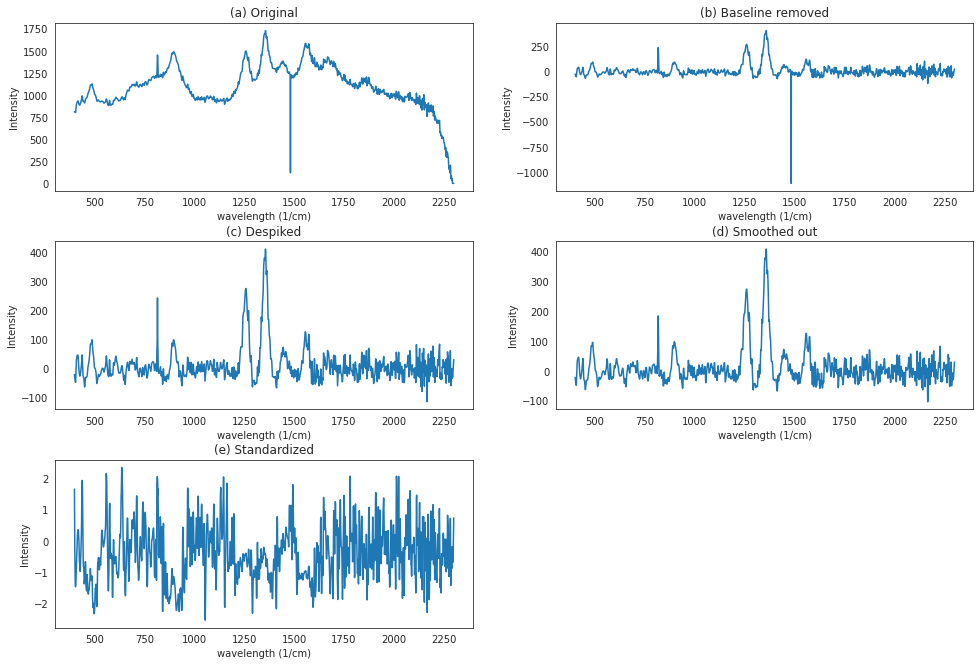

In [11]:
x = np.arange(400, 2301, 1)
# plot with various axes scales
sns.set_style(style="white") 
plt.figure(figsize=[15,10])

plt.subplot(321)
plt.plot(x, y0)
plt.ylabel('Intensity')
plt.xlabel('wavelength (1/cm)')
plt.title('(a) Original')

plt.subplot(322)
plt.plot(x, y1)
plt.ylabel('Intensity')
plt.xlabel('wavelength (1/cm)')
plt.title('(b) Baseline removed')

plt.subplot(323)
plt.plot(x, y2)
plt.ylabel('Intensity')
plt.xlabel('wavelength (1/cm)')
plt.title('(c) Despiked')

plt.subplot(324)
plt.plot(x, y3)
plt.ylabel('Intensity')
plt.xlabel('wavelength (1/cm)')
plt.title('(d) Smoothed out')

plt.subplot(325)
plt.plot(x, y4)
plt.ylabel('Intensity')
plt.xlabel('wavelength (1/cm)')
plt.title('(e) Standardized')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3,
                    wspace=0.2)

plt.show()

# Classificação de sinter em 3 classes de acordo com o RDI

In [12]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rampy
import rampy as rp
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
np.random.seed(145)

# Carregar o arquivo financial_distress.csv
data = pd.read_csv('amostras_ramam_rdi.csv')

# Data de cada amostra
saida = data[['Data','RDI']]
# Retira coluna de datas para treinamento e teste
data = data.drop(['Data'], axis = 1)

# Divisão de classes 0 (<15) 1 (>=15 & <=20) 2 (>20)
group0 = saida['RDI'] >= 15
group1 = saida['RDI'] < 15
group2 = saida['RDI'] <= 20

saida['target'] = saida['RDI'].where(group2, 2) 
saida['target'].where(group0, 0, inplace = True) 
saida['target'].where(group1, 1, inplace = True) 
saida['target'].where(group2, 2, inplace = True) 

saida = saida.astype({"target": int})

# Separar dados em vetores de entrada e saída
X = np.array(data.loc[:, data.columns != 'RDI'])
#RDI classes
y = np.array(saida.loc[:,:])

# Dividir datasets de treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y[:,2].astype('int'))

###########################  Pré-processamento  ################################

#Tirar linha de base
eixo_hor = np.array(data.columns[:-1])
X_treated1 = X_treino.copy()
for i in range(len(X_treated1)):
  Xout1, bas = rp.baseline(eixo_hor, X_treino[i], np.array([[min(eixo_hor), max(eixo_hor)]]), 'arPLS')
  X_treated1[i] = Xout1.reshape(1,1901)
y1 = np.array(X_treated1[amostra]) #Espectro sem linha de base

#Remover picos cósmicos
X_treated2 = X_treino.copy()
wavelength = np.array(data.columns[:-1])
def modified_z_score(intensity):
 median_int = np.median(intensity)
 mad_int = np.median([np.abs(intensity - median_int)])
 modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
 return modified_z_scores
def fixer(y,m):
 threshold = 7 # binarization threshold. 
 spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
 y_out = y.copy() # So we don’t overwrite y
 for i in np.arange(len(spikes)):
    if spikes[i] != 0: # If we have an spike in position i
      if i < (len(spikes)-(m+1)):
        if i > (m):
          w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
          w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
          y_out[i] = np.mean(y[w2]) # and we average their values
 return y_out
for i in range(len(X_treated2)):
  intensity = np.array(X_treated1[i])
  X_treated2[i] = fixer(intensity,m=3)

#Suavização
X_treated3 = X_treino.copy()
for i in range(len(X_treated3)):
  Xout2 = rp.smooth(eixo_hor,X_treated2[i], method="savgol")
  X_treated3[i] = Xout2.reshape(1,1901)

#Padronização
scaler = StandardScaler()
X_treino_std = scaler.fit_transform(X_treated3)

# SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=2, k_neighbors=5)
X_sm, y_sm = oversample.fit_resample(X_treino_std, y_treino[:,2].astype('int'))

#Data augmentation
sigma = 0.5
X_aug = X_sm.copy() 
y_aug = y_sm.copy()
def DA_Jitter(myX, sigma=sigma):
    myNoise = np.random.normal(loc=0, scale=sigma, size=myX.shape)
    return myX+myNoise
for i in range(len(y_sm)): 
  for ii in range(1): 
    X_aug = np.append(X_aug, DA_Jitter(X_sm[i,:].reshape(1,-1)),0) 
    y_aug = np.append(y_aug, y_sm[i]) 

################################  Treino  #####################################

# kNN
knn = KNeighborsClassifier()
# SVM
svm = SVC(kernel='linear', probability=True) 
#Logistic regression
lgr = LogisticRegression()
#Random Forest
forest = RandomForestClassifier(random_state=100)
#Rede MLP
mlp = MLPClassifier(alpha=0.1, random_state=10)

n_classe = 3
y_true, y_pred_knn, y_pred_svm = list(), list(), list()
y_pred_lgr, y_pred_forest, y_pred_mlp = list(), list(), list()
knn_scores, svm_scores, lgr_scores = list(), list(), list()
forest_scores = list()

kf = StratifiedKFold(n_splits=int(len(y_aug)/n_classe), shuffle=True) 
acuracia_val = []
acuracia_treino = []
for train_index, val_index in kf.split(X_aug,y_aug):
  X_train, X_val = X_aug[train_index], X_aug[val_index] 
  y_train, y_val = y_aug[train_index], y_aug[val_index]
  # fit knn model
  knn = knn.fit(X_train, y_train)
  # fit svm model
  svm = svm.fit(X_train, y_train)
  # fit LogisticRegression model
  lgr = lgr.fit(X_train, y_train)
  # fit Random Forest model
  forest = forest.fit(X_train, y_train)

  # Validação
  y_true = np.append(y_true,y_val)
  yhat_knn = knn.predict(X_val)
  yhat_svm = svm.predict(X_val)
  yhat_lgr = lgr.predict(X_val)
  yhat_forest = forest.predict(X_val)

  y_pred_knn = np.append(y_pred_knn, yhat_knn)
  y_pred_svm = np.append(y_pred_svm, yhat_svm)
  y_pred_lgr = np.append(y_pred_lgr, yhat_lgr)
  y_pred_forest = np.append(y_pred_forest, yhat_forest)

  #Treino
  knn_scores = np.append(knn_scores, knn.score(X_train, y_train))
  svm_scores = np.append(svm_scores, svm.score(X_train, y_train))
  lgr_scores = np.append(lgr_scores, lgr.score(X_train, y_train))
  forest_scores = np.append(forest_scores, forest.score(X_train, y_train))

  # Resultados
# fit Rede mlp model
mlp = mlp.fit(X_aug, y_aug)
y_pred_mlp = mlp.predict(X_aug)

print("Treino")
print("%0.2f accuracy of KNN with a standard deviation of %0.2f"% (knn_scores.mean(), knn_scores.std()))
print("%0.2f accuracy of SVM with a standard deviation of %0.2f"% (svm_scores.mean(), svm_scores.std()))
print("%0.2f accuracy of LGR with a standard deviation of %0.2f"% (lgr_scores.mean(), lgr_scores.std()))
print("%0.2f accuracy of Forest with a standard deviation of %0.2f"% (forest_scores.mean(), forest_scores.std()))
print("%0.2f accuracy of MLP"% (mlp.score(X_aug, y_aug)))

################################  Teste  #####################################

#Tirar linha de base
eixo_hor = np.array(data.columns[:-1])
X_treated1 = X_teste.copy()
for i in range(len(X_treated1)):
  Xout1, bas = rp.baseline(eixo_hor, X_teste[i], np.array([[min(eixo_hor), max(eixo_hor)]]), 'arPLS')
  X_treated1[i] = Xout1.reshape(1,1901)

#Remover picos cósmicos
X_treated2 = X_teste.copy()
wavelength = np.array(data.columns[:-1])
def modified_z_score(intensity):
  median_int = np.median(intensity)
  mad_int = np.median([np.abs(intensity - median_int)])
  modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
  return modified_z_scores
def fixer(y,m):
  threshold = 7 # binarization threshold. 
  spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
  y_out = y.copy() # So we don’t overwrite y
  for i in np.arange(len(spikes)):
    if spikes[i] != 0: # If we have an spike in position i
      if i < (len(spikes)-(m+1)):
        if i > (m):
          w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
          w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
          y_out[i] = np.mean(y[w2]) # and we average their values
  return y_out
for i in range(len(X_treated2)):
  intensity = np.array(X_treated1[i])
  X_treated2[i] = fixer(intensity,m=3)

#Suavização
X_treated3 = X_teste.copy()
for i in range(len(X_treated3)):
  Xout2 = rp.smooth(eixo_hor,X_treated2[i], method="savgol")
  X_treated3[i] = Xout2.reshape(1,1901)

#Padronização
X_teste_std = scaler.transform(X_treated3)

y_teste1 = y_teste[:,2].astype('int').copy()
yhat_test_knn =knn.predict(X_teste_std)
yhat_test_svm =svm.predict(X_teste_std)
yhat_test_lgr =lgr.predict(X_teste_std)
yhat_test_forest =forest.predict(X_teste_std)
yhat_test_mlp =mlp.predict(X_teste_std)

print("Teste")
print("Accuraccy KNN: ",knn.score(X_teste_std, y_teste1))
print("Accuraccy SVM: ",svm.score(X_teste_std, y_teste1))
print("Accuraccy LGR: ",lgr.score(X_teste_std, y_teste1))
print("Accuraccy Forest: ",forest.score(X_teste_std, y_teste1))
print("Accuraccy MLP: ",mlp.score(X_teste_std, y_teste1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Treino
0.91 accuracy of KNN with a standard deviation of 0.01
1.00 accuracy of SVM with a standard deviation of 0.00
1.00 accuracy of LGR with a standard deviation of 0.00
1.00 accuracy of Forest with a standard deviation of 0.00
1.00 accuracy of MLP
Teste
Accuraccy KNN:  0.5
Accuraccy SVM:  0.9090909090909091
Accuraccy LGR:  0.9545454545454546
Accuraccy Forest:  0.7727272727272727
Accuraccy MLP:  1.0


**Análise de Resultados**

**Treino**

In [13]:
y_pred_knn = knn.predict(X_aug)
y_pred_svm = svm.predict(X_aug)
y_pred_lgr = lgr.predict(X_aug)
y_pred_forest = forest.predict(X_aug)
y_pred_mlp = mlp.predict(X_aug)

KNN

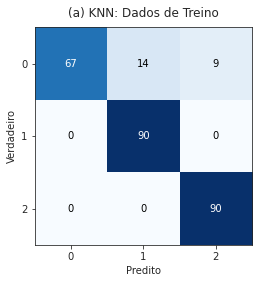

In [14]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_aug,y_pred_knn)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) KNN: Dados de Treino", y=1.02);
plt.show()

In [15]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_aug,y_pred_knn))
print(classification_report(y_aug,y_pred_knn))

[[67 14  9]
 [ 0 90  0]
 [ 0  0 90]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        90
           1       0.87      1.00      0.93        90
           2       0.91      1.00      0.95        90

    accuracy                           0.91       270
   macro avg       0.92      0.91      0.91       270
weighted avg       0.92      0.91      0.91       270



SVM

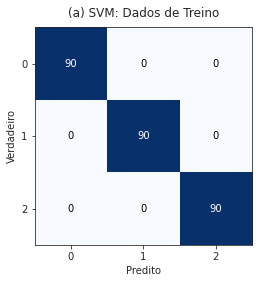

In [16]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_aug,y_pred_svm)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) SVM: Dados de Treino", y=1.02);
plt.show()

In [17]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_aug,y_pred_svm))
print(classification_report(y_aug,y_pred_svm))

[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



LGR

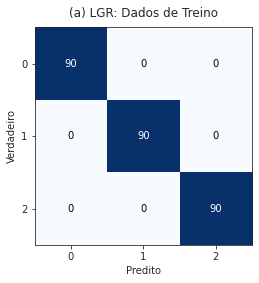

In [18]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_aug,y_pred_lgr)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) LGR: Dados de Treino", y=1.02);
plt.show()

In [19]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_aug,y_pred_lgr))
print(classification_report(y_aug,y_pred_lgr))

[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



RF

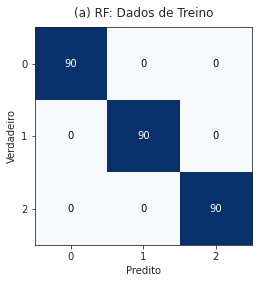

In [20]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_aug,y_pred_forest)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) RF: Dados de Treino", y=1.02);
plt.show()

In [21]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_aug,y_pred_forest))
print(classification_report(y_aug,y_pred_forest))

[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



MLP

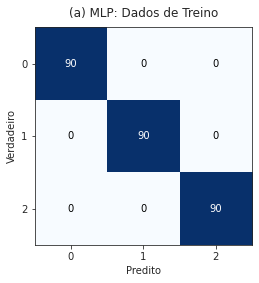

In [22]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_aug,y_pred_mlp)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) MLP: Dados de Treino", y=1.02);
plt.show()

In [23]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_aug,y_pred_mlp))
print(classification_report(y_aug,y_pred_mlp))

[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



**TESTE**

KNN

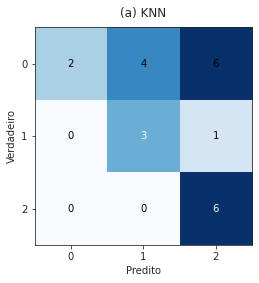

In [24]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste1, yhat_test_knn)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(a) KNN", y=1.02);
plt.show()

In [25]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_teste1, yhat_test_knn))
print(classification_report(y_teste1, yhat_test_knn))

[[2 4 6]
 [0 3 1]
 [0 0 6]]
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.43      0.75      0.55         4
           2       0.46      1.00      0.63         6

    accuracy                           0.50        22
   macro avg       0.63      0.64      0.49        22
weighted avg       0.75      0.50      0.43        22



SVM

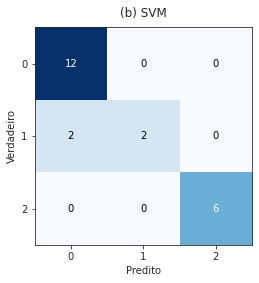

In [26]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste1, yhat_test_svm)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(b) SVM", y=1.02);
plt.show()

In [27]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_teste1, yhat_test_svm))
print(classification_report(y_teste1, yhat_test_svm))

[[12  0  0]
 [ 2  2  0]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.50      0.67         4
           2       1.00      1.00      1.00         6

    accuracy                           0.91        22
   macro avg       0.95      0.83      0.86        22
weighted avg       0.92      0.91      0.90        22



LGR

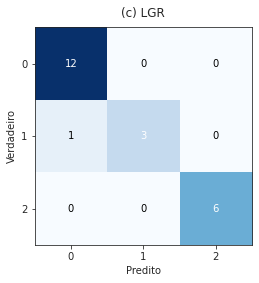

In [28]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste1, yhat_test_lgr)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(c) LGR", y=1.02);
plt.show()

In [29]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_teste1, yhat_test_lgr))
print(classification_report(y_teste1, yhat_test_lgr))

[[12  0  0]
 [ 1  3  0]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         6

    accuracy                           0.95        22
   macro avg       0.97      0.92      0.94        22
weighted avg       0.96      0.95      0.95        22



RF

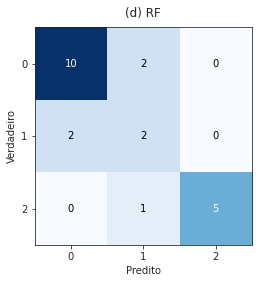

In [30]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste1, yhat_test_forest)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(d) RF", y=1.02);
plt.show()

In [31]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_teste1, yhat_test_forest))
print(classification_report(y_teste1, yhat_test_forest))

[[10  2  0]
 [ 2  2  0]
 [ 0  1  5]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.40      0.50      0.44         4
           2       1.00      0.83      0.91         6

    accuracy                           0.77        22
   macro avg       0.74      0.72      0.73        22
weighted avg       0.80      0.77      0.78        22



MLP

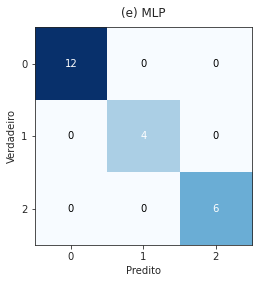

In [32]:
#realiza o plot da matriz de confusão
matriz_confusao = confusion_matrix(y_teste1, yhat_test_mlp)
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("(e) MLP", y=1.02);
plt.show()

In [33]:
#constroi a matriz de confusão para comparar o modelo criado
print(confusion_matrix(y_teste1, yhat_test_mlp))
print(classification_report(y_teste1, yhat_test_mlp))

[[12  0  0]
 [ 0  4  0]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [34]:
class_names = ['Classe 0','Classe 1', 'Classe 2' ]
def plot_value_array(i, predictions_array, true_label, rdi_value):
  predictions_array, true_label, rdi_value = predictions_array[i], true_label[i], rdi_value[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  if predicted_label == true_label:
    c = 'blue'
  else:
    c = 'red'
  
  plt.xlabel("{}; {:2.0f}% \n ({}. RDI = {})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label],
                                rdi_value),
                                color=c, fontsize=10)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

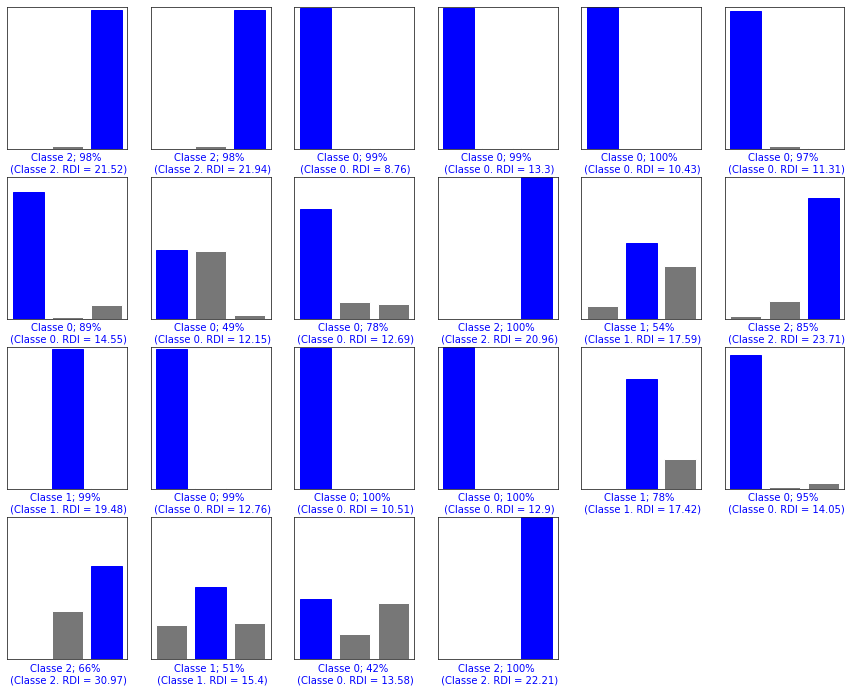

In [35]:
mlp_predictions = mlp.predict_proba(X_teste_std)

# Color correct predictions in blue, incorrect predictions in red
num_rows = 4
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2.5*num_cols, 3*num_rows))
for i in range(len(y_teste1)):
  plt.subplot(num_rows, num_cols, i+1)
  plot_value_array(i, mlp_predictions, y_teste1, y_teste[:,1])

# Regressão

In [36]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rampy
import rampy as rp
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
np.random.seed(5)

# Carregar o arquivo financial_distress.csv
data = pd.read_csv('amostras_ramam_rdi.csv')

# Data de cada amostra
saida = data[['Data','RDI']]
# Retira coluna de datas para treinamento e teste
data = data.drop(['Data'], axis = 1)

# Separar dados em vetores de entrada e saída
X = np.array(data.loc[:, data.columns != 'RDI'])
#RDI classes
y = np.array(data.loc[:,data.columns == 'RDI'])

# Dividir datasets de treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True)

amostra = 0

###########################  Pré-processamento  ################################

#Tirar linha de base
y0 = X_treino[amostra]  #Espectro original
eixo_hor = np.array(data.columns[:-1])
#a = np.zeros((84,1901))
X_treated1 = X_treino.copy()
for i in range(len(X_treated1)):
  Xout1, bas = rp.baseline(eixo_hor, X_treino[i], np.array([[min(eixo_hor), max(eixo_hor)]]), 'arPLS')
  X_treated1[i] = Xout1.reshape(1,1901)
y1 = np.array(X_treated1[amostra]) #Espectro sem linha de base

#Remover picos cósmicos
X_treated2 = X_treino.copy()
wavelength = np.array(data.columns[:-1])
def modified_z_score(intensity):
 median_int = np.median(intensity)
 mad_int = np.median([np.abs(intensity - median_int)])
 modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
 return modified_z_scores
def fixer(y,m):
 threshold = 7 # binarization threshold. 
 spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
 y_out = y.copy() # So we don’t overwrite y
 for i in np.arange(len(spikes)):
    if spikes[i] != 0: # If we have an spike in position i
      if i < (len(spikes)-(m+1)):
        if i > (m):
          w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
          w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
          y_out[i] = np.mean(y[w2]) # and we average their values
 return y_out
for i in range(len(X_treated2)):
  intensity = np.array(X_treated1[i])
  X_treated2[i] = fixer(intensity,m=3)
y2 = np.array(X_treated2[amostra]) #Espectro sem picos cósmicos

#Suavização
X_treated3 = X_treino.copy()
for i in range(len(X_treated3)):
  Xout2 = rp.smooth(eixo_hor,X_treated2[i], method="savgol")
  X_treated3[i] = Xout2.reshape(1,1901)
y3 = np.array(X_treated3[amostra]) #Espectro suavizado

#Padronização
scaler = StandardScaler()
X_treino_std = scaler.fit_transform(X_treated3)
y4 = np.array(X_treino_std[amostra]) #Espectro normalizado

sigma = 0.5
X_aug = X_treino_std.copy() 
y_aug = y_treino.copy() 
def DA_Jitter(myX, sigma=sigma):
    myNoise = np.random.normal(loc=0, scale=sigma, size=myX.shape)
    return myX+myNoise
for i in range(len(y_treino)): 
  for ii in range(1): 
    X_aug = np.append(X_aug, DA_Jitter(X_treino_std[i,:].reshape(1,-1)),0) 
    y_aug = np.append(y_aug, y_treino[i]) 

################################  Treino  #####################################
lr = LinearRegression().fit(X_aug, y_aug)
svr = SVR().fit(X_aug, y_aug) 
forest = RandomForestRegressor(random_state=0).fit(X_aug, y_aug)

print('Treino')
print('R2 LR: ', lr.score(X_aug, y_aug)) # retorna o R2
print('R2 SVR: ', svr.score(X_aug, y_aug)) # retorna o R2
print('R2 Forest: ', forest.score(X_aug, y_aug)) # retorna o R2
print('\n')

MSE_train_lr = mean_squared_error(y_aug,lr.predict(X_aug)) # encontra o MSE através do sklearn
MSE_train_svr = mean_squared_error(y_aug,svr.predict(X_aug)) # encontra o MSE através do sklearn
MSE_train_forest = mean_squared_error(y_aug,forest.predict(X_aug)) # encontra o MSE através do sklearn

print('MSE Linear: ', MSE_train_lr)
print('MSE SVR: ', MSE_train_svr)
print('MSE Forest: ', MSE_train_forest)
print('\n')

MAE_train_lr = mean_absolute_error(y_aug,lr.predict(X_aug)) # encontra o MAE através do sklearn
MAE_train_svr = mean_absolute_error(y_aug,svr.predict(X_aug)) # encontra o MAE através do sklearn
MAE_train_forest = mean_absolute_error(y_aug,forest.predict(X_aug)) # encontra o MAE através do sklearn

print('MAE Linear: ', MAE_train_lr)
print('MAE SVR: ', MAE_train_svr)
print('MAE Forest: ', MAE_train_forest)
print('\n')

################################  Teste  #####################################
amostra = 5 
#Tirar linha de base
eixo_hor = np.array(data.columns[:-1])
X_treated1 = X_teste.copy()
for i in range(len(X_treated1)):
  Xout1, bas = rp.baseline(eixo_hor, X_teste[i], np.array([[min(eixo_hor), max(eixo_hor)]]), 'arPLS')
  X_treated1[i] = Xout1.reshape(1,1901)

#Remover picos cósmicos
X_treated2 = X_teste.copy()
wavelength = np.array(data.columns[:-1])
def modified_z_score(intensity):
  median_int = np.median(intensity)
  mad_int = np.median([np.abs(intensity - median_int)])
  modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
  return modified_z_scores
def fixer(y,m):
  threshold = 7 # binarization threshold. 
  spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
  y_out = y.copy() # So we don’t overwrite y
  for i in np.arange(len(spikes)):
    if spikes[i] != 0: # If we have an spike in position i
      if i < (len(spikes)-(m+1)):
        if i > (m):
          w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
          w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
          y_out[i] = np.mean(y[w2]) # and we average their values
  return y_out
for i in range(len(X_treated2)):
  intensity = np.array(X_treated1[i])
  X_treated2[i] = fixer(intensity,m=3)

#Suavização
X_treated3 = X_teste.copy()
for i in range(len(X_treated3)):
  Xout2 = rp.smooth(eixo_hor,X_treated2[i], method="savgol")
  X_treated3[i] = Xout2.reshape(1,1901)

#Padronização
X_teste_std = scaler.transform(X_treated3)

print('Teste')
print('R2 LR: ', lr.score(X_teste_std, y_teste))
print('R2 SVR: ', svr.score(X_teste_std, y_teste))
print('R2 Forest: ', forest.score(X_teste_std, y_teste))
print('\n')

MSE_lr = mean_squared_error(y_teste,lr.predict(X_teste_std)) # encontra o MSE através do sklearn
MSE_svr = mean_squared_error(y_teste,svr.predict(X_teste_std)) # encontra o MSE através do sklearn
MSE_forest = mean_squared_error(y_teste,forest.predict(X_teste_std)) # encontra o MSE através do sklearn

print('MSE Linear: ', MSE_lr)
print('MSE SVR: ', MSE_svr)
print('MSE Forest: ', MSE_forest)
print('\n')

MAE_lr = mean_absolute_error(y_teste,lr.predict(X_teste_std)) # encontra o MAE através do sklearn
MAE_svr = mean_absolute_error(y_teste,svr.predict(X_teste_std)) # encontra o MAE através do sklearn
MAE_forest = mean_absolute_error(y_teste,forest.predict(X_teste_std)) # encontra o MAE através do sklearn

print('MAE Linear: ', MAE_lr)
print('MAE SVR: ', MAE_svr)
print('MAE Forest: ', MAE_forest)

Treino
R2 LR:  1.0
R2 SVR:  0.5449589347504099
R2 Forest:  0.946813569643348


MSE Linear:  3.5870632304549723e-28
MSE SVR:  12.76330426481117
MSE Forest:  1.4918095205952409


MAE Linear:  1.2751704454266084e-14
MAE SVR:  2.1943189904366687
MAE Forest:  0.8608916666666679


Teste
R2 LR:  0.702728769134242
R2 SVR:  0.49157324853160667
R2 Forest:  0.5353960236374248


MSE Linear:  6.282004993469175
MSE SVR:  10.744192709923146
MSE Forest:  9.818119604090903


MAE Linear:  1.952614515088438
MAE SVR:  2.3379131594193128
MAE Forest:  2.1454772727272733


**Análise dos resultados de regressão**

**Análise Treino**

LR

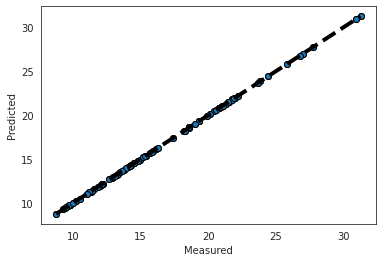

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_aug, lr.predict(X_aug), edgecolors=(0, 0, 0))
ax.plot([y_aug.min(), y_aug.max()], [y_aug.min(), y_aug.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

SVR

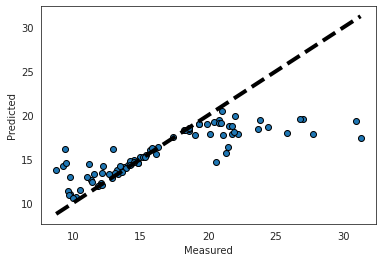

In [38]:
fig, ax = plt.subplots()
ax.scatter(y_treino, svr.predict(X_treino_std), edgecolors=(0, 0, 0))
ax.plot([y_treino.min(), y_treino.max()], [y_treino.min(), y_treino.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

RF

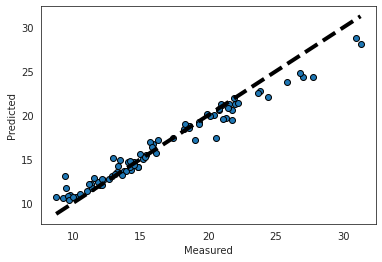

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_treino, forest.predict(X_treino_std), edgecolors=(0, 0, 0))
ax.plot([y_treino.min(), y_treino.max()], [y_treino.min(), y_treino.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

**Análise Teste**

LR

In [40]:
print("RDI predito LR: ",lr.predict(X_teste_std))

RDI predito LR:  [16.37792805 22.53748967 14.572128    7.71415668 12.86276855 12.71974435
 12.34700058 12.0126484   9.7628632  17.52666568 15.99672367 18.27866465
 17.41997071 18.88711448 14.83751825 12.79207086 14.54470582  8.70215117
 25.76336763 14.99135818 13.1582687  15.7925305 ]


In [41]:
print("RDI real:",y_teste.reshape(1,22))

RDI real: [[19.18 19.65 14.05 10.43 12.15 13.4  11.28 10.99 11.93 13.58 19.48 20.51
  17.59 12.96 14.9  14.63 14.03  9.65 30.74 12.14 12.76 14.76]]


In [42]:
erro = lr.predict(X_teste_std) - y_teste.reshape(1,22)
print("RDI real:",abs(erro))

RDI real: [[2.80207195 2.88748967 0.522128   2.71584332 0.71276855 0.68025565
  1.06700058 1.0226484  2.1671368  3.94666568 3.48327633 2.23133535
  0.17002929 5.92711448 0.06248175 1.83792914 0.51470582 0.94784883
  4.97663237 2.85135818 0.3982687  1.0325305 ]]


In [43]:
abs(erro).max()

5.927114480161393

In [44]:
abs(erro).min()

0.062481748347908095

LR


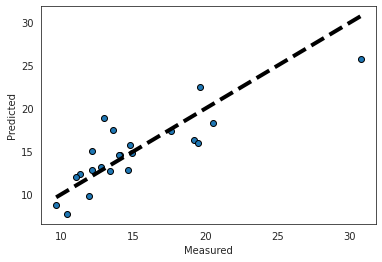

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_teste, lr.predict(X_teste_std), edgecolors=(0, 0, 0))
ax.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

SVR

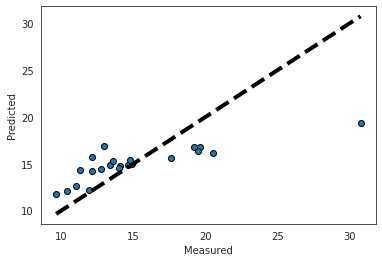

In [46]:
fig, ax = plt.subplots()
ax.scatter(y_teste, svr.predict(X_teste_std), edgecolors=(0, 0, 0))
ax.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

RF

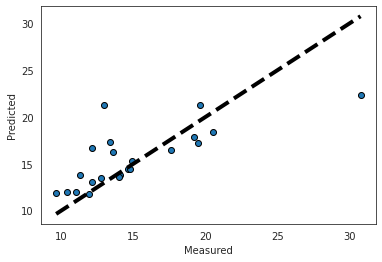

In [47]:
fig, ax = plt.subplots()
ax.scatter(y_teste, forest.predict(X_teste_std), edgecolors=(0, 0, 0))
ax.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()